# Import library and dataset

In [1]:
# !pip install tensorflow-gpu

In [2]:
import pandas as pd
import numpy as np

# Also data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# sklearn for splitting the data
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

# tensorflow 
import tensorflow as tf # version=2.1.0

In [3]:
print(tf.__version__)

2.1.0


In [4]:
# data=pd.read_csv('/gdrive/My Drive/Bangkit/fake_job_postings.csv') #if using colab
data=pd.read_csv('fake_job_postings.csv')

data.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


# Data analysis

In [5]:
# Check the number of record for each class

(data[data.fraudulent == 0].shape), (data[data.fraudulent == 1].shape)

((17014, 18), (866, 18))

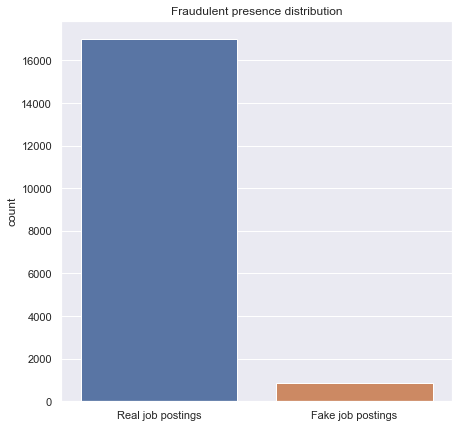

In [6]:
# Fraudulent presence distribution 

plt.figure(figsize=(7,7))
f = sns.countplot(x='fraudulent', data=data)
f.set_title("Fraudulent presence distribution")
f.set_xticklabels(['Real job postings', 'Fake job postings'])
plt.xlabel("");

Text(0.5,1,'Employement type ditribution of REAL job postings')

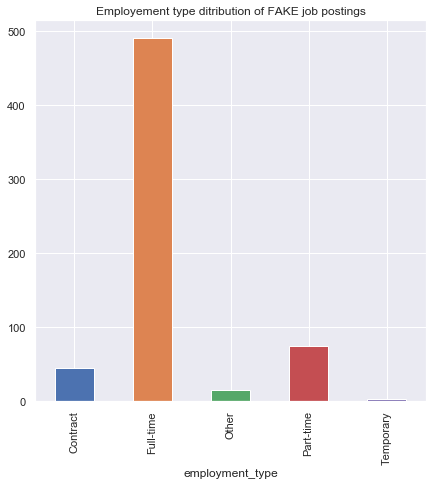

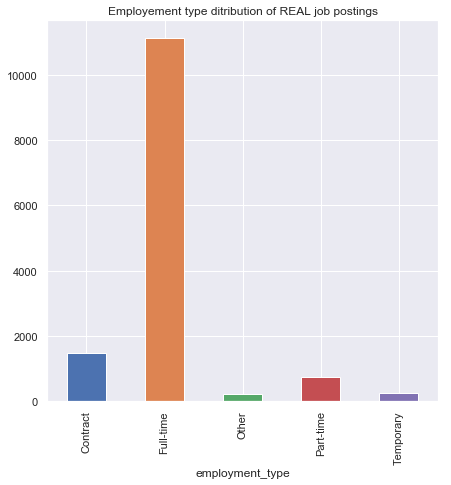

In [7]:
# Employement type of FAKE/REAL job postings

plt.figure(figsize=(7,7))
data[data['fraudulent']==1].groupby('employment_type')['employment_type'].count().plot(kind='bar')
plt.title('Employement type ditribution of FAKE job postings')

plt.figure(figsize=(7,7))
data[data['fraudulent']==0].groupby('employment_type')['employment_type'].count().plot(kind='bar')
plt.title('Employement type ditribution of REAL job postings')

# Selecting feature

In [8]:
# Drop unused field to making a model

df = data.drop(columns=['job_id','title','location','department','company_profile','description','requirements','benefits'])

In [9]:
print('Drop some field of the dataset\n')
print('Shape of dataset before : ',data.shape)
print('Shape of dataset after : ',df.shape)

Drop some field of the dataset

Shape of dataset before :  (17880, 18)
Shape of dataset after :  (17880, 10)


# Checking NaN value

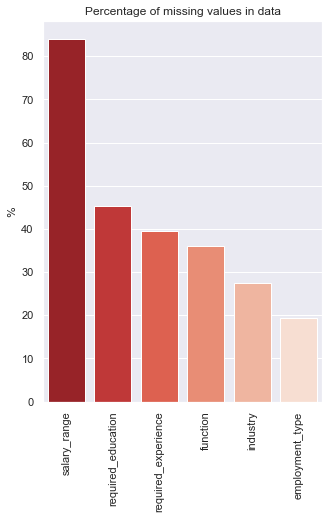

In [10]:
# check target nan value in the data 

combined = df.copy()
nan_percentage = combined.isnull().sum().sort_values(ascending=False) / combined.shape[0]
missing_val = nan_percentage[nan_percentage > 0]

plt.figure(figsize=(5,7))
sns.barplot(x=missing_val.index.values, y=missing_val.values * 100, palette="Reds_r");
plt.title("Percentage of missing values in data");
plt.ylabel("%");
plt.xticks(rotation=90);

# Taking care NaN value

```
Because salary_range has more than 50% NaN value of the data, so we will drop the feature of salary range. And the rest that contain NaN value is required_education, required_experience, function, industry, and employment_type. Those field which contain NaN value less than 50% will not dropped and will be replaced by string '-'. The reason why those value is not dropped or not replaced by other string that have rasional value is because in this case we think NaN value is not a missing value. So instead of we dropped or replace with rasional value, we think that NaN value is literally still NaN value.
```

In [11]:
# Drop column salary range 

df = df.drop(['salary_range'], axis=1)

In [12]:
# Replace NaN with '-' string

df = df.fillna('-')

In [13]:
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,-,-,Marketing,0
1,0,1,0,Full-time,Not Applicable,-,Marketing and Advertising,Customer Service,0
2,0,1,0,-,-,-,-,-,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Count categorical variable from the data

In [14]:
pd.DataFrame([{'employment_type': len(df['employment_type'].value_counts()),    
               'required_experience': len(df['required_experience'].value_counts()),
               'required_education': len(df['required_education'].value_counts()),
               'industry': len(df['industry'].value_counts()),
               'function': len(df['function'].value_counts()),
              }], columns = ['employment_type', 'required_experience', 'required_education', 'industry', 'function'], 
              index = ['quantity of unique value'])

,employment_type,required_experience,required_education,industry,function
quantity of unique value,6,8,14,132,38


# Creating feature columns from our data

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 9 columns):
telecommuting          17880 non-null int64
has_company_logo       17880 non-null int64
has_questions          17880 non-null int64
employment_type        17880 non-null object
required_experience    17880 non-null object
required_education     17880 non-null object
industry               17880 non-null object
function               17880 non-null object
fraudulent             17880 non-null int64
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [16]:
CATEGORICAL_COLUMNS = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
NUMERIC_COLUMNS = ['telecommuting', 'has_company_logo', 'has_questions']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = df[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Splitting the data

In [17]:
X=df.drop("fraudulent", axis=1)
y=df["fraudulent"]

In [18]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state=7)

# Define input function

In [19]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

In [20]:
type(y_test)

pandas.core.series.Series

In [21]:
ds = make_input_fn(X_train, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['employment_type'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

A batch of class: [b'Full-time' b'-' b'Contract' b'Contract' b'-' b'Full-time' b'-'
 b'Full-time' b'Full-time' b'Full-time']

A batch of Labels: [0 0 0 1 0 0 0 0 0 0]


# Fit linear classifier algorithm and evaluate the result

In [22]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.9539061, 'accuracy_baseline': 0.9493306, 'auc': 0.87659985, 'auc_precision_recall': 0.39700872, 'average_loss': 0.14240184, 'label/mean': 0.05066938, 'loss': 0.14211349, 'precision': 0.754717, 'prediction/mean': 0.045631398, 'recall': 0.13377926, 'global_step': 3750}


In [23]:
res_prediction = list(linear_est.predict(eval_input_fn))

In [24]:
res_prediction

[{'logits': array([-4.0011406], dtype=float32),
  'logistic': array([0.01796607], dtype=float32),
  'probabilities': array([0.98203385, 0.01796607], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1]),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-3.0466862], dtype=float32),
  'logistic': array([0.04536076], dtype=float32),
  'probabilities': array([0.95463926, 0.04536076], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1]),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-1.6196244], dtype=float32),
  'logistic': array([0.1652567], dtype=float32),
  'probabilities': array([0.8347433 , 0.16525668], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1]),
  'all_classes': array([b'0', b'1'], dtype=object)},

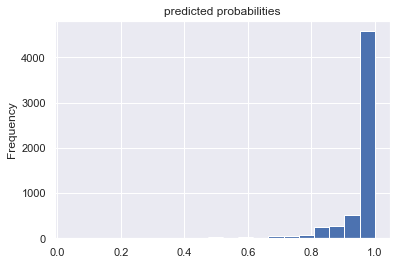

In [25]:
probs = pd.Series([pred['probabilities'][0] for pred in res_prediction])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

<h3>The result of the prediction give a conclusion that for each data that predicted using this model, have a high accuracy that proofing the prediction is correct</h3>


In [26]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

### Receiver Operating Characteristic (ROC) of the results
it is show a better idea of the tradeoff between the true positive rate and false positive rate.

(0, 1.05)

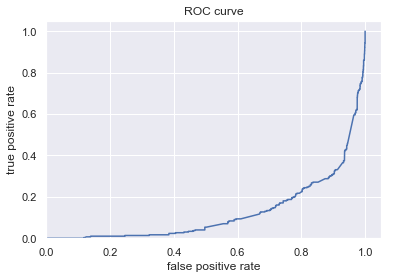

In [27]:
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

# Saving the model 

In [28]:
serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
  tf.feature_column.make_parse_example_spec(feature_columns))

In [29]:
linear_est.export_saved_model(export_dir_base='model', serving_input_receiver_fn=serving_input_fn)

W0405 02:46:34.963313  1660 deprecation.py:323] From C:\Users\PERSONALISE NOTEBOOK\Anaconda3\lib\site-packages\tensorflow_core\python\saved_model\signature_def_utils_impl.py:145: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


b'model\\1586029594'

# Build some testing

```
We trying to predict new data which actually the data is from data testing which is X_test and already have the label. 
In this section we will set the label with -1 and see the prediction of our model.
```

In [30]:
pred = pd.DataFrame([[0,1,1,'Full-time','Mid-Senior level','High School or equivalent','Oil & Energy','Other', -1], 
                     [0,1,1,'Full-time','-',"Bachelor's Degree",'Information Technology and Services','Engineering', -1]],
                    columns=['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function', "fraud"])

In [31]:
pred

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraud
0,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,-1
1,0,1,1,Full-time,-,Bachelor's Degree,Information Technology and Services,Engineering,-1


In [32]:
x_pred = pred.drop(['fraud'], axis=1)
y_pred = pred['fraud']

test_input_fn = make_input_fn(pred, y_pred, num_epochs=1, shuffle=False, batch_size=2)

prediction = list(linear_est.predict(test_input_fn))

In [33]:
prediction = pd.DataFrame(prediction)
prediction['classes']

0    [b'0']
1    [b'0']
Name: classes, dtype: object

# Analyze the result

```
Unfortunately, instead of produce class 1 our model predict those 2 rows with 0. Why?
When our team trying to get deep dive with the data, we know that the data is not good enough because 
the difference between real job and fake job posting is so far which 17014-866 = 16148 (its only 4.84% for the 
data that labelled as fake job posting). Means that we very deficiency of fake job posting's data.
```

```
But, our accuracy for data evaluation is very good which s 95%. It's because the data validation that we used for 
calculate the accuracy is only contain 299 rows of class = 1 (fake job posting) and for class = 0 (real job posting) 
is contain 5602 rows.
```

```
5602+299 = 5901 rows
299/5901 *100% = 5.06693781% 
Our accuracy baseline is 0.9493306 = 100% - 5.06693781% 

BOOM

After that, we wondering is the model can predict rows with label class = 1? And the answer is below
```

In [34]:
eval_1 = pd.concat([X_test, y_test], axis=1)
eval_1 = eval_1[eval_1.fraudulent == 1]

In [35]:
X_test = eval_1.drop("fraudulent", axis=1)
y_test = eval_1["fraudulent"]

In [36]:
eval_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

In [37]:
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.13377926, 'accuracy_baseline': 1.0, 'auc': 0.0, 'auc_precision_recall': 0.99999994, 'average_loss': 2.0681415, 'label/mean': 1.0, 'loss': 2.0447621, 'precision': 1.0, 'prediction/mean': 0.23362413, 'recall': 0.13377926, 'global_step': 3750}


# Conclusion


##### After we do some evaluation for the label = 1, we got the accuracy = 13.37%. that accuracy is calculated with only using label = 1. And we got the result that it is not because the training model was bad, but because the data is still less information and very less fake job description's data to making very good prediction for fake or real job postings.
